Combined Voice + Facial Recognition Model

Libraries

In [ ]:



! pip install voila
! pip install pandas scikit-learn
! pip install --upgrade matplotlib

! pip install numpy

! pip install transformers dataset 
! pip install torch
! pip install tf-keras
! pip install pandas 
! pip install ffmpeg-python
! pip install ipywidgets
! pip install streamlit

import os
import subprocess
from PIL import Image
from transformers import pipeline
import cv2
import numpy as np

import time
import matplotlib.pyplot as plt
from mtcnn import MTCNN


^C


With weighted scores

In [2]:
import sys
import threading
import imageio
import time
import tkinter as tk
from tkinter import scrolledtext
import numpy as np
from PIL import Image
from transformers import pipeline
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile as wav
import os
import cv2



detector = MTCNN()



pipe = pipeline(
    "image-classification",
    model="dima806/facial_emotions_image_detection",
    device=-1 
)


hf_emotions = {
    'Happy': 0,
    'Sad': 0,
    'Angry': 0,
    'Surprise': 0,
    'Neutral': 0,
    'Fear': 0,
    'Disgust': 0,
}
hf_confidence_scores = {key: 0 for key in hf_emotions}


emotion_weighted_scores = {
    'happy_weighted_score': 0,
    'sad_weighted_score': 0,
    'angry_weighted_score': 0,
    'surprise_weighted_score': 0,
    'neutral_weighted_score': 0,
    'fear_weighted_score': 0,
    'disgust_weighted_score': 0
}

recording = False
audio_filename = r"C:\Users\Anjali\Downloads\audio_vocal_recognition.wav"  
audio_recording = False
audio_buffer = []  


sampling_rate = 44100  


root = tk.Tk()
root.title("Emotion Detection")


output_text = scrolledtext.ScrolledText(root, width=50, height=10)
output_text.pack(padx=10, pady=10)


start_button = tk.Button(root, text="Start Recording", command=lambda: start_recording())
start_button.pack(padx=10, pady=5)

stop_button = tk.Button(root, text="Stop Recording", command=lambda: stop_recording())
stop_button.pack(padx=10, pady=5)

def hf(frame):
    """Process frame with HuggingFace model and track emotions and confidence scores."""
    try:
        pil_image = Image.fromarray(frame)
        results = pipe(pil_image)
        emotion_label = results[0]['label'].capitalize()
        confidence = results[0]['score']

        if emotion_label in hf_emotions:
            hf_emotions[emotion_label] += 1
            hf_confidence_scores[emotion_label] = (hf_confidence_scores.get(emotion_label, 0) + confidence) / 2

        print(f"HuggingFace Emotion: {emotion_label} (Confidence: {confidence:.2f})")
    except Exception as e:
        print(f"Error processing frame with HuggingFace: {e}")

def data():
    """Display the emotion distribution as a pie chart, print confidence scores, and calculate weighted scores."""
    global emotion_weighted_scores 
    total = sum(hf_emotions.values())

    percentages = {emotion: (count / total) * 100 if total > 0 else 0 for emotion, count in hf_emotions.items()}

    print("Emotion Distribution:")
    for emotion, percentage in percentages.items():
        print(f"{emotion.capitalize()}: {percentage:.2f}%")

    for emotion in hf_emotions:
       
        weighted_score = percentages[emotion] * hf_confidence_scores[emotion] 

        
        if emotion == 'Happy':
            emotion_weighted_scores['happy_weighted_score'] = weighted_score
        elif emotion == 'Sad':
            emotion_weighted_scores['sad_weighted_score'] = weighted_score
        elif emotion == 'Angry':
            emotion_weighted_scores['angry_weighted_score'] = weighted_score
        elif emotion == 'Surprise':
            emotion_weighted_scores['surprise_weighted_score'] = weighted_score
        elif emotion == 'Neutral':
            emotion_weighted_scores['neutral_weighted_score'] = weighted_score
        elif emotion == 'Fear':
            emotion_weighted_scores['fear_weighted_score'] = weighted_score
        elif emotion == 'Disgust':
            emotion_weighted_scores['disgust_weighted_score'] = weighted_score

        # Output the emotion's weighted score and confidence
        print(f"Variable: {emotion.lower()}_weighted_score - Weighted Score: {weighted_score:.2f}, Confidence: {hf_confidence_scores[emotion]:.2f}")

    emotion_colors = {
        'Angry': '#b03c3c', 
        'Disgust': '#74a86d', 
        'Fear': '#8178ad',
        'Happy': '#ffe675', 
        'Sad': '#6b85c7',
        'Surprise': '#ffb5b5', 
        'Neutral': '#c5c6c7'
    }
    
    labels = list(percentages.keys())
    sizes = list(percentages.values())
    
    filtered_labels = [label for label, size in zip(labels, sizes) if size > 0]
    filtered_sizes = [size for size in sizes if size > 0]
    
    filtered_colors = [emotion_colors[label] for label in filtered_labels]
    
    if filtered_sizes:
        plt.figure(figsize=(8, 8))
        plt.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct='%1.1f%%', startangle=140)
        plt.title("Emotion Distribution")
        plt.show()

def process_webcam():
    """Process the webcam feed and update emotion counters and confidence scores."""
    global recording
    
    reader = imageio.get_reader('<video1>')

    for frame in reader:
        if not recording:  
            break

        frame_bgr = np.array(frame)

        faces = detector.detect_faces(frame_bgr)
        if len(faces) == 0:  
            continue

        for face in faces:
            x, y, w, h = face['box']
            cropped_face = frame_bgr[y:y + h, x:x + w]
            hf(cropped_face)
            
      

def start_recording():
    """Start the emotion detection and audio recording."""
    global recording, audio_recording, audio_buffer
    
    
    
    recording = True
    audio_recording = True
    audio_buffer = []
    
    
    threading.Thread(target=process_webcam, daemon=True).start()

  
    threading.Thread(target=start_audio_recording, daemon=True).start()

def start_audio_recording():
    """Record audio and store it in the audio buffer."""
    def callback(indata, frames, time, status):
        if status:
            print(status, file=sys.stderr)
        audio_buffer.append(indata.copy())

    with sd.InputStream(callback=callback, channels=1, samplerate=sampling_rate):
        while audio_recording:
            time.sleep(0.1)

def stop_recording():
    """Stop the recording and save audio to file."""
    global recording, audio_recording
    recording = False
    audio_recording = False
    
    data()
    
   
    if audio_buffer:
        audio_data = np.concatenate(audio_buffer, axis=0)
        wav.write(audio_filename, sampling_rate, audio_data)
        print(f"Audio saved to {audio_filename}")


root.mainloop()


Device set to use cpu


Emotion Distribution:
Happy: 0.00%
Sad: 0.00%
Angry: 0.00%
Surprise: 0.00%
Neutral: 0.00%
Fear: 0.00%
Disgust: 0.00%
Variable: happy_weighted_score - Weighted Score: 0.00, Confidence: 0.00
Variable: sad_weighted_score - Weighted Score: 0.00, Confidence: 0.00
Variable: angry_weighted_score - Weighted Score: 0.00, Confidence: 0.00
Variable: surprise_weighted_score - Weighted Score: 0.00, Confidence: 0.00
Variable: neutral_weighted_score - Weighted Score: 0.00, Confidence: 0.00
Variable: fear_weighted_score - Weighted Score: 0.00, Confidence: 0.00
Variable: disgust_weighted_score - Weighted Score: 0.00, Confidence: 0.00
Audio saved to C:\Users\Anjali\Downloads\audio_vocal_recognition.wav


Voice + Integrated Output

Device set to use cpu
c:\Users\Anjali\anaconda3\Lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Transcript saved to: C:\Users\Anjali\Downloads\participant_transcript.csv


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Average Pitch:  60.19
No voice detected or pitch outside valid range. Emotion distribution set to 1%.

Emotion Distribution:
Happiness: 1.00%
Sadness: 1.00%
Frustration: 1.00%
Anger: 1.00%
Neutral: 1.00%

Weighted Scores:
Happiness: 0.00
Sadness: 0.00
Frustration: 0.00
Anger: 0.00
Neutral: 0.00


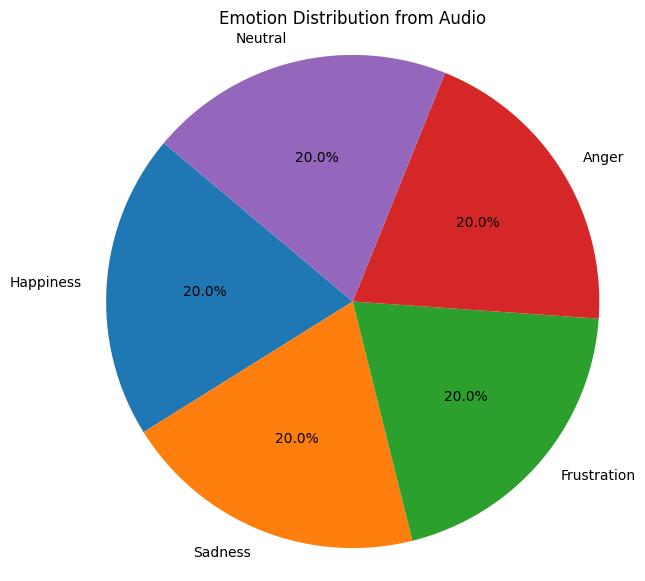

NameError: name 'chart_window' is not defined

In [3]:
import os
import pandas as pd
from transformers import pipeline
import librosa
import joblib
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

global Happiness_weighted_score, Sadness_weighted_score, Frustration_weighted_score, Anger_weighted_score, Neutral_weighted_score
Happiness_weighted_score = 0
Sadness_weighted_score = 0
Frustration_weighted_score = 0
Anger_weighted_score = 0
Neutral_weighted_score = 0


audio_file_path = "C:/Users/Anjali/Downloads/audio_vocal_recognition.wav"
file_path = r'C:\Users\Anjali\Downloads\participant_transcript.csv'


emotion_dict = {0: 'Happiness', 1: 'Sadness', 2: 'Frustration', 3: 'Anger', 4: 'Neutral'}
recall_values = {'Happiness': 0.9, 'Sadness': 0.9, 'Frustration': 0.75, 'Anger': 1, 'Neutral': 0.62}


def extract_pitch_segment(audio_data, sr):
    fmin = librosa.note_to_hz('C1')
    fmax = librosa.note_to_hz('C8')
    pitches, voiced_flag, _ = librosa.pyin(audio_data, fmin=fmin, fmax=fmax, sr=sr)
    pitches = pitches[~np.isnan(pitches)]
    if len(pitches) > 0:
        average_pitch = round(np.mean(pitches), 2)
        pitch_variance = round(np.var(pitches), 2)
        return average_pitch, pitch_variance
    else:
        return None, None


classifier = pipeline("automatic-speech-recognition", model="openai/whisper-medium", return_timestamps=True)

def process_audio(model_path):
    global Happiness_weighted_score, Sadness_weighted_score, Frustration_weighted_score, Anger_weighted_score, Neutral_weighted_score
    
    
    transcription = classifier(audio_file_path)
    text = transcription['text']
    

    
    sentences = text.split('.')
    sentences = [sentence.strip() for sentence in sentences if sentence.strip() and len(sentence.strip()) > 2]
    df = pd.DataFrame({"Transcription": sentences})
    df.to_csv(file_path, index=False)
    print(f"Transcript saved to: {file_path}")

   
    sentiment_classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
    sentiments = [sentiment_classifier(sentence)[0]['label'] for sentence in sentences]
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True) * 100
    sentiment_counts = sentiment_counts.round(2)

    positive_score = sentiment_counts.get('positive', 0)
    neutral_score = sentiment_counts.get('neutral', 0)
    negative_score = sentiment_counts.get('negative', 0)

    
    y, sr = librosa.load(audio_file_path, sr=16000)
    average_pitch, pitch_variance = extract_pitch_segment(y, sr)
    amplitude = np.sqrt(np.mean(y**2))

    print("Average Pitch: ", average_pitch)

   
    if average_pitch is None or average_pitch < 80 or average_pitch > 500:
        print("No voice detected or pitch outside valid range. Emotion distribution set to 1%.")
        emotion_probs = {emotion_dict[i]: 1 for i in range(len(emotion_dict))}
        
        
        Happiness_weighted_score = 0
        Sadness_weighted_score = 0
        Frustration_weighted_score = 0
        Anger_weighted_score = 0
        Neutral_weighted_score = 0
    else:
      
        model = joblib.load(model_path)
        scaler = joblib.load('scaler.joblib')

        
        new_data = pd.DataFrame({
            'Positive': [positive_score],
            'Neutral': [neutral_score],
            'Negative': [negative_score],
            'Pitch': [average_pitch],
            'Pitch Variance': [pitch_variance],
            'Amplitude': [amplitude]
        })

       
        new_data_scaled = scaler.transform(new_data)
        predicted_probs = model.predict_proba(new_data_scaled)[0]
        emotion_probs = {emotion_dict[i]: predicted_probs[i] * 100 for i in range(len(emotion_dict))}

        
        Happiness_weighted_score = emotion_probs['Happiness'] * recall_values['Happiness']
        Sadness_weighted_score = emotion_probs['Sadness'] * recall_values['Sadness']
        Frustration_weighted_score = emotion_probs['Frustration'] * recall_values['Frustration']
        Anger_weighted_score = emotion_probs['Anger'] * recall_values['Anger']
        Neutral_weighted_score = emotion_probs['Neutral'] * recall_values['Neutral']

    # Print emotion distribution and weighted scores
    print("\nEmotion Distribution:")
    for emotion, probability in emotion_probs.items():
        print(f"{emotion}: {probability:.2f}%")

    print("\nWeighted Scores:")
    print(f"Happiness: {Happiness_weighted_score:.2f}")
    print(f"Sadness: {Sadness_weighted_score:.2f}")
    print(f"Frustration: {Frustration_weighted_score:.2f}")
    print(f"Anger: {Anger_weighted_score:.2f}")
    print(f"Neutral: {Neutral_weighted_score:.2f}")

    # pie chart of face
    plt.figure(figsize=(7, 7))
    plt.pie(emotion_probs.values(), labels=emotion_probs.keys(), autopct='%1.1f%%', startangle=140)
    plt.title('Emotion Distribution from Audio')
    plt.axis('equal')
    plt.show()

if __name__ == "__main__":
    process_audio('F_RandomForestEmotionModel.joblib')
    
    

import tkinter as tk
from tkinter import messagebox





final_change_happiness = emotion_weighted_scores['happy_weighted_score'] + Happiness_weighted_score
final_change_sadness = emotion_weighted_scores['sad_weighted_score'] + Sadness_weighted_score
final_change_frustration = Frustration_weighted_score
final_change_anger = emotion_weighted_scores['angry_weighted_score'] + Anger_weighted_score
final_change_neutral = emotion_weighted_scores['neutral_weighted_score'] + Neutral_weighted_score
final_change_disgust = emotion_weighted_scores['disgust_weighted_score']
final_change_fear = emotion_weighted_scores['fear_weighted_score']
final_change_surprise = emotion_weighted_scores['surprise_weighted_score']

total_sum = (final_change_happiness + final_change_sadness + final_change_frustration +
             final_change_anger + final_change_neutral + final_change_disgust +
             final_change_fear + final_change_surprise)

transcript_file_path = r"C:\Users\Anjali\Downloads\participant_transcript.csv"
transcript_data = pd.read_csv(transcript_file_path)


if total_sum == 0:
    # No voice + No face
    messagebox.showinfo("Detection Result", "Device Failure")
else:
    

    whisper_transcript = "\n".join(transcript_data['Transcription'].astype(str))

   
    chart_window = tk.Tk()
    chart_window.title("Emotion Distribution")
    title_label = tk.Label(chart_window, text="Emotion Distribution", font=("Arial", 16, "bold"))
    title_label.pack()

    transcript_label = tk.Label(chart_window, text="Whisper Transcript:", font=("Arial", 12))
    transcript_label.pack()

    
    transcript_text = tk.Text(chart_window, height=10, width=50)
    transcript_text.pack()

   
    transcript_text.insert(tk.END, whisper_transcript)


    normalized_final_happiness = final_change_happiness / total_sum
    normalized_final_sadness = final_change_sadness / total_sum
    normalized_final_frustration = final_change_frustration / total_sum
    normalized_final_anger = final_change_anger / total_sum
    normalized_final_neutral = final_change_neutral / total_sum
    normalized_final_disgust = final_change_disgust / total_sum
    normalized_final_fear = final_change_fear / total_sum
    normalized_final_surprise = final_change_surprise / total_sum

    print("Normalized Final Happiness:", normalized_final_happiness * 100)
    print("Normalized Final Sadness:", normalized_final_sadness * 100)
    print("Normalized Final Frustration:", normalized_final_frustration * 100)
    print("Normalized Final Anger:", normalized_final_anger * 100)
    print("Normalized Final Neutral:", normalized_final_neutral * 100)
    print("Normalized Final Disgust:", normalized_final_disgust * 100)
    print("Normalized Final Fear:", normalized_final_fear * 100)
    print("Normalized Final Surprise:", normalized_final_surprise * 100)

    
    emotions = ['Happiness', 'Sadness', 'Frustration', 'Anger', 'Neutral', 'Disgust', 'Fear', 'Surprise']
    normalized_values = [
        normalized_final_happiness, 
        normalized_final_sadness, 
        normalized_final_frustration, 
        normalized_final_anger, 
        normalized_final_neutral, 
        normalized_final_disgust, 
        normalized_final_fear, 
        normalized_final_surprise
    ]

    
    filtered_emotions = []
    filtered_values = []

    for emotion, value in zip(emotions, normalized_values):
        if value > 0: 
            filtered_emotions.append(emotion)
            filtered_values.append(value)

    #pie chart
    fig, ax = plt.subplots()
    ax.pie(filtered_values, labels=filtered_emotions, autopct='%1.1f%%', startangle=90, 
           colors=['gold', 'blue', 'orange', 'red', 'gray', 'purple', 'green', 'pink'])
    ax.axis('equal')

    canvas = FigureCanvasTkAgg(fig, master=chart_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    # Check if for no face or no voice
    if all(value == 0 for value in emotion_weighted_scores.values()):
        no_face_label = tk.Label(chart_window, text="No face detected", font=("Arial", 12, "bold"), fg="red")
        no_face_label.pack()

    elif all(value == 0 for value in [Happiness_weighted_score, Sadness_weighted_score, 
                                      Frustration_weighted_score, Anger_weighted_score, 
                                      Neutral_weighted_score]):
        no_voice_label = tk.Label(chart_window, text="No voice detected", font=("Arial", 12, "bold"), fg="red")
        no_voice_label.pack()
        transcript_text.delete(1.0, tk.END)
        transcript_text.insert(tk.END, "none")


chart_window.mainloop()


In [ ]:


final_change_happiness = emotion_weighted_scores['happy_weighted_score'] + Happiness_weighted_score
final_change_sadness = emotion_weighted_scores['sad_weighted_score'] + Sadness_weighted_score
final_change_frustration = Frustration_weighted_score
final_change_anger = emotion_weighted_scores['angry_weighted_score'] + Anger_weighted_score
final_change_neutral = emotion_weighted_scores['neutral_weighted_score'] + Neutral_weighted_score
final_change_disgust = emotion_weighted_scores['disgust_weighted_score']
final_change_fear = emotion_weighted_scores['fear_weighted_score']
final_change_surprise = emotion_weighted_scores['surprise_weighted_score']

total_sum = (final_change_happiness + final_change_sadness + final_change_frustration +
             final_change_anger + final_change_neutral + final_change_disgust +
             final_change_fear + final_change_surprise)

transcript_file_path = r"C:\Users\Anjali\Downloads\participant_transcript.csv"
transcript_data = pd.read_csv(transcript_file_path)


if total_sum == 0:
    
    messagebox.showinfo("Detection Result", "No face or voice detected")
else:
    

    whisper_transcript = "\n".join(transcript_data['Transcription'].astype(str))

    
    chart_window = tk.Tk()
    chart_window.title("Emotion Distribution")
    title_label = tk.Label(chart_window, text="Emotion Distribution", font=("Arial", 16, "bold"))
    title_label.pack()

    transcript_label = tk.Label(chart_window, text="Whisper Transcript:", font=("Arial", 12))
    transcript_label.pack()

    
    transcript_text = tk.Text(chart_window, height=10, width=50)
    transcript_text.pack()

    
    transcript_text.insert(tk.END, whisper_transcript)

    
    normalized_final_happiness = final_change_happiness / total_sum
    normalized_final_sadness = final_change_sadness / total_sum
    normalized_final_frustration = final_change_frustration / total_sum
    normalized_final_anger = final_change_anger / total_sum
    normalized_final_neutral = final_change_neutral / total_sum
    normalized_final_disgust = final_change_disgust / total_sum
    normalized_final_fear = final_change_fear / total_sum
    normalized_final_surprise = final_change_surprise / total_sum

    print("Normalized Final Happiness:", normalized_final_happiness * 100)
    print("Normalized Final Sadness:", normalized_final_sadness * 100)
    print("Normalized Final Frustration:", normalized_final_frustration * 100)
    print("Normalized Final Anger:", normalized_final_anger * 100)
    print("Normalized Final Neutral:", normalized_final_neutral * 100)
    print("Normalized Final Disgust:", normalized_final_disgust * 100)
    print("Normalized Final Fear:", normalized_final_fear * 100)
    print("Normalized Final Surprise:", normalized_final_surprise * 100)

    
    emotions = ['Happiness', 'Sadness', 'Frustration', 'Anger', 'Neutral', 'Disgust', 'Fear', 'Surprise']
    normalized_values = [
        normalized_final_happiness, 
        normalized_final_sadness, 
        normalized_final_frustration, 
        normalized_final_anger, 
        normalized_final_neutral, 
        normalized_final_disgust, 
        normalized_final_fear, 
        normalized_final_surprise
    ]

    
    filtered_emotions = []
    filtered_values = []

    for emotion, value in zip(emotions, normalized_values):
        if value > 0: 
            filtered_emotions.append(emotion)
            filtered_values.append(value)

    #pie chart
    fig, ax = plt.subplots()
    ax.pie(filtered_values, labels=filtered_emotions, autopct='%1.1f%%', startangle=90, 
           colors=['gold', 'blue', 'orange', 'red', 'gray', 'purple', 'green', 'pink'])
    ax.axis('equal')

    canvas = FigureCanvasTkAgg(fig, master=chart_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    
    if all(value == 0 for value in emotion_weighted_scores.values()):
        no_face_label = tk.Label(chart_window, text="No face detected", font=("Arial", 12, "bold"), fg="red")
        no_face_label.pack()

    elif all(value == 0 for value in [Happiness_weighted_score, Sadness_weighted_score, 
                                      Frustration_weighted_score, Anger_weighted_score, 
                                      Neutral_weighted_score]):
        no_voice_label = tk.Label(chart_window, text="No voice detected", font=("Arial", 12, "bold"), fg="red")
        no_voice_label.pack()


chart_window.mainloop()